High Performance Python
=======

Lecture 7. Numba
----------

Heavily based on (forked): 

Scipy2017 tutorial by Gil Forsyth:

https://github.com/gforsyth/numba_tutorial_scipy2017

https://www.youtube.com/watch?v=1AwG0T4gaO0&t=1349s

GTC2018 tutorial by Stan Seibert:

https://github.com/ContinuumIO/gtc2018-numba


High Performance Python
----------------------

* multiprocessing
* mpi4py
* pycuda
* cupy
* pyopencl
* **numba**

Numba is:

Just-In-Time (JIT) compiler:
* generates optimized machine code using LLVM
* integrates well with Scientific Python stack
* **function compiler**: Numba compiles Python functions (not entire applications and not parts of functions). Numba is a Python module.
* **type-specializing**: Numba speeds up your function by generating a specialized implementation for the specific data types you are using. 
* **just-in-time**: Numba translates functions when they are first called so that the compiler knows the argument types. Works in Jupyter notebook.
* **numerically-focused**: „mostly“ int, float, complex. Works good with numpy arrays.


The first step is always to find the bottlenecks in your code, via _profiling_: analyzing your code by measuring the execution time of its parts.


Tools:
------

2. `cProfile`
4. `snakeviz`
1. [`line_profiler`](https://github.com/rkern/line_profiler)
3. `timeit`



```console
pip install line_profiler
```

In [26]:
!pip install numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 6.2 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 6.0 MB/s eta 0:00:00m eta 0:00:010:00:01


In [32]:
# !pip install snakeviz

In [33]:
import numba as nb

import matplotlib.pyplot as plt
from numba import jit, njit

import snakeviz
import line_profiler
import cProfile

In [48]:
import numpy
from time import sleep

def sleepy(time2sleep):
    sleep(time2sleep)
    
def supersleepy(time2sleep):
    sleep(time2sleep)
    
def randmatmul(n=1000):
    a = numpy.random.random((n,n))
    b = a @ a
    return b
    
def useless(a):
    if not isinstance(a, int):
        return
    
    randmatmul(a)
    
    ans = 0
    for i in range(a):
        ans += i
        
    sleepy(1.0)
    supersleepy(2.0)
        
    return ans

## using `cProfile`

[`cProfile`](https://docs.python.org/3.4/library/profile.html#module-cProfile) is the built-in profiler in Python (available since Python 2.5).  It provides a function-by-function report of execution time. First import the module, then usage is simply a call to `cProfile.run()` with your code as argument. It will print out a list of all the functions that were called, with the number of calls and the time spent in each.


In [49]:
import cProfile

cProfile.run('useless(3000)')

         11 function calls in 3.707 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.600    0.600    0.702    0.702 4020217437.py:10(randmatmul)
        1    0.002    0.002    3.707    3.707 4020217437.py:15(useless)
        1    0.000    0.000    1.001    1.001 4020217437.py:4(sleepy)
        1    0.000    0.000    2.002    2.002 4020217437.py:7(supersleepy)
        1    0.000    0.000    3.707    3.707 <string>:1(<module>)
        1    0.000    0.000    3.707    3.707 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        2    3.003    1.502    3.003    1.502 {built-in method time.sleep}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.102    0.102    0.102    0.102 {method 'random' of 'numpy.random.mtrand.RandomState' objects}




## using `snakeviz`

In [50]:
%load_ext snakeviz

In [51]:
%snakeviz useless(3000)

 
*** Profile stats marshalled to file '/tmp/tmpql090cgl'.
Embedding SnakeViz in this document...


## using `line_profiler`

`line_profiler` offers more granular information than `cProfile`: it will give timing information about each line of code in a profiled function.

### For a pop-up window with results in notebook:

IPython has an `%lprun` magic to profile specific functions within an executed statement. Usage:
`%lprun -f func_to_profile <statement>` (get more help by running `%lprun?` in IPython).

In [52]:
%load_ext line_profiler
%lprun -f sleepy -f supersleepy useless(1000)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


### Write results to a text file

In [ ]:
%lprun -T timings.txt -f sleepy useless(1000)

## Profiling on the command line

Open file, add `@profile` decorator to any function you want to profile, then run

```console
kernprof -l script_to_profile.py
```

which will generate `script_to_profile.py.lprof` (pickled result).  To view the results, run

```console
python -m line_profiler script_to_profile.py.lprof
```

In [53]:
from IPython.display import IFrame
IFrame('http://localhost:8888/terminals/1', width=800, height=700)

## `timeit`

```python
python -m timeit "print(42)"
```


In [54]:
# line magic
%timeit x=10

18.1 ns ± 0.215 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [55]:
%%timeit 
# cell magic

x=10
a='hello'
d=[1,2,3]

92.7 ns ± 3.7 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


JIT
===

### Array sum

The function below is a naive `sum` function that sums all the elements of a given array.

In [57]:
def sum_array(inp):
    J, I = inp.shape
    
    #this is a bad idea
    mysum = 0
    for j in range(J):
        for i in range(I):
            mysum += inp[j, i]
            
    return mysum

In [58]:
import numpy
arr = numpy.random.random((300, 300))

sum_array(arr)

plain = %timeit -o sum_array(arr)

20.3 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
from numba import jit

sum_array_numba = jit()(sum_array)

sum_array_numba(arr)

jitted = %timeit -o sum_array_numba(arr)

plain.best / jitted.best


167 µs ± 7.89 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


118.40700135802854

## More commonly as a decorator

In [60]:
@jit
def sum_array(inp):
    I, J = inp.shape
    
    mysum = 0
    for i in range(I):
        for j in range(J):
            mysum += inp[i, j]
            
    return mysum

In [61]:
%timeit arr.sum()

37.3 µs ± 452 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Exercise 1. JIT the Mandelbrot fractal
--------------------------------------------

Separate exercise notebook or use your own Mandelbrot code 

1. Profile the code, find the bottlenecks
2. Use Numba to speed up the code
3. Compare the timing

In [62]:
@jit
def add(a, b):
    return a + b

In [63]:
add(1, 1)

2

Numba examines Python bytecode and then translates this into an 'intermediate representation'.  To view this IR, run (compile) `add` and you can access the `inspect_types` method.

In [64]:
add.inspect_types()

add (int64, int64)
--------------------------------------------------------------------------------
# File: /tmp/ipykernel_27399/2002586577.py
# --- LINE 1 --- 

@jit

# --- LINE 2 --- 

def add(a, b):

    # --- LINE 3 --- 
    # label 0
    #   a = arg(0, name=a)  :: int64
    #   b = arg(1, name=b)  :: int64
    #   $6binary_add.2 = a + b  :: int64
    #   del b
    #   del a
    #   $8return_value.3 = cast(value=$6binary_add.2)  :: int64
    #   del $6binary_add.2
    #   return $8return_value.3

    return a + b




Ok.  Numba is has correctly inferred the type of the arguments, defining things as `int64` and running smoothly.  

(What happens if you do `add(1., 1.)` and then `inspect_types`?)

In [65]:
add(1.,1.)

2.0

In [66]:
add.inspect_types()

add (int64, int64)
--------------------------------------------------------------------------------
# File: /tmp/ipykernel_27399/2002586577.py
# --- LINE 1 --- 

@jit

# --- LINE 2 --- 

def add(a, b):

    # --- LINE 3 --- 
    # label 0
    #   a = arg(0, name=a)  :: int64
    #   b = arg(1, name=b)  :: int64
    #   $6binary_add.2 = a + b  :: int64
    #   del b
    #   del a
    #   $8return_value.3 = cast(value=$6binary_add.2)  :: int64
    #   del $6binary_add.2
    #   return $8return_value.3

    return a + b


add (float64, float64)
--------------------------------------------------------------------------------
# File: /tmp/ipykernel_27399/2002586577.py
# --- LINE 1 --- 

@jit

# --- LINE 2 --- 

def add(a, b):

    # --- LINE 3 --- 
    # label 0
    #   a = arg(0, name=a)  :: float64
    #   b = arg(1, name=b)  :: float64
    #   $6binary_add.2 = a + b  :: float64
    #   del b
    #   del a
    #   $8return_value.3 = cast(value=$6binary_add.2)  :: float64
    #   del $6bin

### What about the actual LLVM code?

You can see the actual LLVM code generated by Numba using the `inspect_llvm()` method.  Since it's a `dict`, doing the following will be slightly more visually friendly.

In [67]:
for k, v in add.inspect_llvm().items():
    print(k, v)

(int64, int64) ; ModuleID = 'add'
source_filename = "<string>"
target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-unknown-linux-gnu"

@_ZN08NumbaEnv8__main__3addB3v13B44c8tJTIcFHzwl2ILiXkcBLaFgF0XXBPQ5mKUJAA_3d_3dExx = common local_unnamed_addr global i8* null
@.const.add = internal constant [4 x i8] c"add\00"
@PyExc_RuntimeError = external global i8
@".const.missing Environment: _ZN08NumbaEnv8__main__3addB3v13B44c8tJTIcFHzwl2ILiXkcBLaFgF0XXBPQ5mKUJAA_3d_3dExx" = internal constant [103 x i8] c"missing Environment: _ZN08NumbaEnv8__main__3addB3v13B44c8tJTIcFHzwl2ILiXkcBLaFgF0XXBPQ5mKUJAA_3d_3dExx\00"

; Function Attrs: nofree norecurse nounwind writeonly
define i32 @_ZN8__main__3addB3v13B44c8tJTIcFHzwl2ILiXkcBLaFgF0XXBPQ5mKUJAA_3d_3dExx(i64* noalias nocapture %retptr, { i8*, i32, i8* }** noalias nocapture readnone %excinfo, i64 %arg.a, i64 %arg.b) local_unnamed_addr #0 {
entry:
  %.6 = add nsw i64 %arg.b, %arg.a
  store i6

## But there's a caveat
Now, watch what happens when we try to do something that is natural in Python, but not particularly mathematically sound:

In [68]:
from numba import njit

In [69]:
def add_strings(a, b):
    return a + b

In [70]:
add_strings_jit = njit()(add_strings)

In [71]:
add_strings_jit('a', 'b')

'ab'

In [72]:
add_strings_jit.inspect_types()

add_strings (unicode_type, unicode_type)
--------------------------------------------------------------------------------
# File: /tmp/ipykernel_27399/582987202.py
# --- LINE 1 --- 

def add_strings(a, b):

    # --- LINE 2 --- 
    # label 0
    #   a = arg(0, name=a)  :: unicode_type
    #   b = arg(1, name=b)  :: unicode_type
    #   $6binary_add.2 = a + b  :: unicode_type
    #   del b
    #   del a
    #   $8return_value.3 = cast(value=$6binary_add.2)  :: unicode_type
    #   del $6binary_add.2
    #   return $8return_value.3

    return a + b




### Compiler options

```python
cache=True
```

if you don't want to always want to get dinged by the compilation time for every run. This will actually save the compiled function into something like a `pyc` file in your `__pycache__` directory, so even between sessions you should have nice fast performance.

In [92]:
#implementing code for fractal generation from our previous julia set implementation to compare speeds
#I used it rather than the basic mandlebrot fractal to include parameter c and play around with it 

In [73]:
golden = (1 + 5 ** 0.5) / 2

In [74]:
def julia_map(z, c):
    return z ** 2 + c


def check_for_convergence(z, c, n_iterations, max_module):
    converges = True
    
    for i in range(1, n_iterations + 1):
        z = julia_map(z, c)
        
        if abs(z) > max_module:
            converges = False
            break
    
    ratio = i / n_iterations
    return ratio, converges


def initialize_julia_set(x_range, y_range):
    return np.zeros((x_range, y_range))


def construct_julia_set(x_range, y_range, x_min, y_min, x_max, y_max, c, max_module, n_iterations):
    width, height = x_max - x_min, y_max - y_min
    julia_set = initialize_julia_set(x_range, y_range)

    for i in range(x_range):
        for j in range(y_range):

            z = complex(i / x_range * width + x_min, j / y_range * height + y_min)
            ratio, converges = check_for_convergence(z, c, n_iterations, max_module)
            julia_set[i, j] = 1 - np.sqrt(ratio)
    
    return julia_set

In [75]:
x_range, y_range = 500, 500

x_min, x_max = -1.5, 1.5
width = x_max - x_min

y_min, y_max = -1.5, 1.5
height = y_max - y_min

In [76]:
c = 1 - golden
max_module = 4
n_iterations = 200

In [77]:
args = (x_range, y_range, x_min, y_min, x_max, y_max, c, max_module, n_iterations)

In [78]:
%%time
_ = construct_julia_set(*args)

CPU times: user 5.17 s, sys: 3.82 ms, total: 5.17 s
Wall time: 5.18 s


In [79]:
factor = 1e2
rr = np.logspace(0, 4, 5, base=2).astype(int) * int(factor)
results_original_code = []

for r in rr:
    x_range = y_range = r

    sup_args = (x_range, y_range, x_min, y_min, x_max, y_max, c, max_module, n_iterations)
    results = %timeit -n 1 -o construct_julia_set(*sup_args)

    results_original_code.append(results.best)

results_original_code = np.array(results_original_code)

217 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
843 ms ± 94.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.07 s ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.3 s ± 668 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
49.1 s ± 2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
cProfile.run('construct_julia_set(*args)')

         28799688 function calls in 9.093 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 14274841    2.685    0.000    2.685    0.000 3750789470.py:1(julia_map)
        1    0.000    0.000    0.000    0.000 3750789470.py:19(initialize_julia_set)
        1    0.548    0.548    9.093    9.093 3750789470.py:23(construct_julia_set)
   250000    4.533    0.000    8.544    0.000 3750789470.py:5(check_for_convergence)
        1    0.000    0.000    9.093    9.093 <string>:1(<module>)
 14274841    1.326    0.000    1.326    0.000 {built-in method builtins.abs}
        1    0.000    0.000    9.093    9.093 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [81]:
%load_ext line_profiler
%lprun -T line_profiler_output.txt -f construct_julia_set construct_julia_set(*args)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler

*** Profile printout saved to text file 'line_profiler_output.txt'. 


In [82]:
!cat line_profiler_output.txt

Timer unit: 1e-09 s

Total time: 9.91982 s
File: /tmp/ipykernel_27399/3750789470.py
Function: construct_julia_set at line 23

Line #      Hits         Time  Per Hit   % Time  Line Contents
    23                                           def construct_julia_set(x_range, y_range, x_min, y_min, x_max, y_max, c, max_module, n_iterations):
    24         1       3346.0   3346.0      0.0      width, height = x_max - x_min, y_max - y_min
    25         1     658170.0 658170.0      0.0      julia_set = initialize_julia_set(x_range, y_range)
    26                                           
    27       500     163826.0    327.7      0.0      for i in range(x_range):
    28    250000   65963157.0    263.9      0.7          for j in range(y_range):
    29                                           
    30    250000  185020406.0    740.1      1.9              z = complex(i / x_range * width + x_min, j / y_range * height + y_min)
    31    250000 9185439413.0  36741.8     92.6              ratio, 

In [83]:
#using numba

@njit
def julia_map(z, c):
    return z ** 2 + c


@njit
def check_for_convergence(z, c, n_iterations, max_module):
    converges = True
    
    for i in range(1, n_iterations + 1):
        z = julia_map(z, c)
        
        if abs(z) > max_module:
            converges = False
            break
    
    ratio = i / n_iterations
    return ratio, converges


@njit
def initialize_julia_set(x_range, y_range):
    return np.zeros((x_range, y_range))

@njit
def construct_julia_set(x_range, y_range, x_min, y_min, x_max, y_max, c, max_module, n_iterations):
    width, height = x_max - x_min, y_max - y_min
    julia_set = initialize_julia_set(x_range, y_range)

    for i in range(x_range):
        for j in range(y_range):

            z = complex(i / x_range * width + x_min, j / y_range * height + y_min)
            ratio, converges = check_for_convergence(z, c, n_iterations, max_module)
            julia_set[i, j] = 1 - np.sqrt(ratio)
    
    return julia_set

In [84]:
%%time
_ = construct_julia_set(*args)

CPU times: user 828 ms, sys: 8 ms, total: 836 ms
Wall time: 835 ms


In [85]:
factor = 1e2
rr = np.logspace(0, 4, 5, base=2).astype(int) * int(factor)
results_compiled_code = []

for r in rr:
    x_range = y_range = r

    sup_args = (x_range, y_range, x_min, y_min, x_max, y_max, c, max_module, n_iterations)
    results = %timeit -n 1 -o construct_julia_set(*sup_args)

    results_compiled_code.append(results.best)

results_compiled_code = np.array(results_compiled_code)

9.38 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
30 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
120 ms ± 794 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
505 ms ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.94 s ± 47.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


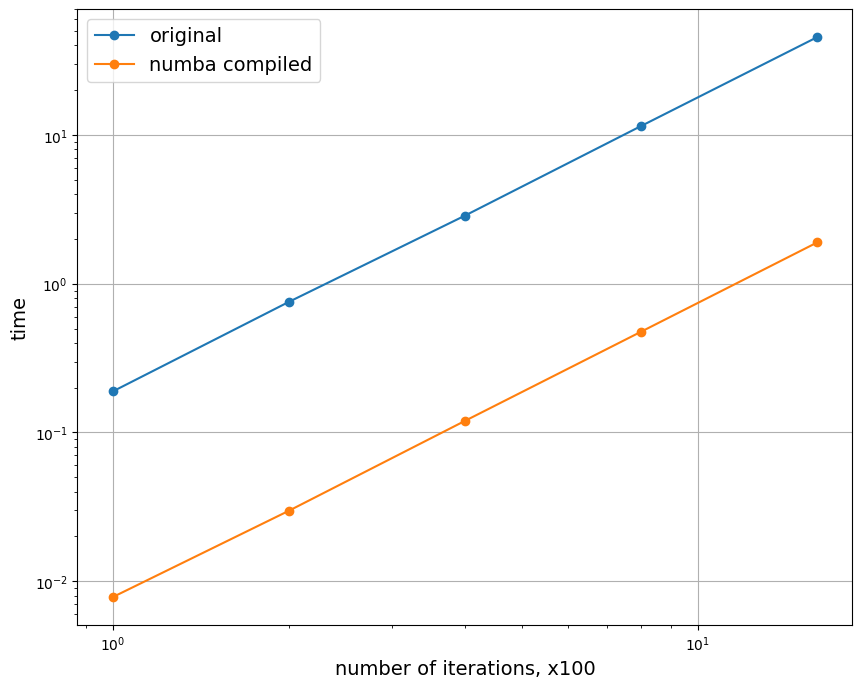

In [87]:
###speed comparison of original vs numba 
plt.figure(figsize=(10, 8))

plt.plot(rr / factor, results_original_code, '-o', label='original')
plt.plot(rr / factor, results_compiled_code, '-o', label='numba compiled')

plt.xlabel(f'number of iterations, x{int(factor)}', fontsize=14)
plt.ylabel('time', fontsize=14)

plt.yscale('log')
plt.xscale('log')

plt.legend(fontsize=14)
plt.grid()
plt.show()

In [ ]:
results_original_code / results_compiled_code

## N-Body problems

Many physical problems require the evaluation of all pairwise interactions of a large number of particles, so-called N-body problems. These problems arise in molecular dynamics, astrodynamics and electromagnetics among others. 

Their pairwise interactions can be expressed as:

\begin{equation}
f_i = \sum_{j=1}^n{P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)w_j} \ \ \ \text{for } i=1,2,...,n 
\end{equation}

*  where subscripts $i$,  $j$ respectively denote *target* and *source*
*  $f_i$ can be a *potential* (or *force*) at target point $i$
*  $w_j$ is the *source weight* 
*  $\boldsymbol{x}_i, \boldsymbol{x}_j$ are the *spatial positions* of particles 
*  $P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)$ is the *interaction kernel*. 

In order to evalute the potential $f_i$ at a target point $i$, we have to loop over each source particle $j$. Since there are $n$ target points $i$, this 'brute-force' approach costs $\mathcal{O} \left(n^2 \right)$ operations. 

One possible approach in this kind of problem is to define a few classes, say `Point` and `Particle` and then loop over the objects and perform the necessary point-to-point calculations.

In [7]:
import numpy

In [8]:
class Point():
    """    
    Arguments:
        domain: the domain of random generated coordinates x,y,z, 
                default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, domain=1.0):
        self.x = domain * numpy.random.random()
        self.y = domain * numpy.random.random()
        self.z = domain * numpy.random.random()
            
    def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5

In [9]:
class Particle(Point):
    """    
    Attributes:
        m: mass of the particle
        phi: the potential of the particle
    """
    
    def __init__(self, domain=1.0, m=1.0):
        Point.__init__(self, domain)
        self.m = m
        self.phi = 0.

In [10]:

def create_n_random_particles(n, m, domain=1.0):
    return [Particle(domain, m) for _ in range(n)]

Now we create a list of `n` random particles, define a function to calculate their interaction via direct summation and run!

In [11]:
n = 1000
particles = [Particle(m = 1 / n) for i in range(n)]

In [12]:
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

In [13]:
%%time
direct_sum(particles)

CPU times: user 811 ms, sys: 0 ns, total: 811 ms
Wall time: 814 ms


In [14]:
orig_time = %timeit -o direct_sum(particles)

799 ms ± 7.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
!pip install line_profiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 673.6/673.6 kB 4.9 MB/s eta 0:00:004.9 MB/s eta 0:00:01


In [17]:
%load_ext line_profiler

In [18]:
%lprun -f direct_sum direct_sum(particles)

## How do we use Numba on this problem?
Problem: Numba doesn't support jitting native Python classes.  There is a `jit_class` structure in Numba but it's still in early development.

But it's nice to have attributes for literate programming.

Solution: NumPy custom dtypes.

In [19]:
particle_dtype = numpy.dtype({'names':['x','y','z','m','phi'], 
                             'formats':[numpy.double, 
                                        numpy.double, 
                                        numpy.double, 
                                        numpy.double, 
                                        numpy.double]})

In [20]:
myarray = numpy.ones(3, dtype=particle_dtype)

In [21]:
myarray

array([(1., 1., 1., 1., 1.), (1., 1., 1., 1., 1.), (1., 1., 1., 1., 1.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')])

In [22]:
myarray[0]['x'] = 2.0

In [23]:
myarray

array([(2., 1., 1., 1., 1.), (1., 1., 1., 1., 1.), (1., 1., 1., 1., 1.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')])

### Exercise 1

Write a function `create_n_random_particles` that takes the arguments `n` (number of particles), `m` (mass of every particle) and a domain within to generate a random number (as in the class above).
It should create an array with `n` elements and `dtype=particle_dtype` and then return that array.

For each particle, the mass should be initialized to the value of `m` and the potential `phi` initialized to zero.

For the `x` component of a given particle `p`, you might do something like

```python
p['x'] = domain * numpy.random.random()
```

In [34]:
@njit
def create_n_random_particles(n, m, domain=1.0):
    '''
    Creates `n` particles with mass `m` with random coordinates
    between 0 and `domain`
    '''
    particles = np.zeros((n), dtype=particle_dtype)

    for particle in particles:
        particle['x'] = domain * np.random.random()
        particle['y'] = domain * np.random.random()
        particle['z'] = domain * np.random.random()

        particle['m'] = m

    return particles

In [36]:
# test it
parts = create_n_random_particles(1000, .001, 1)

### Exercise 2

Write a JITted function `distance` to calculate the distance between two particles of dtype `particle_dtype`

Here's the `distance` method from the `Particle` class as a reference:

```python
def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5
```

In [37]:
@njit
def distance(particle_1, particle_2):
    '''calculate the distance between two particles'''
    
    return ((particle_1['x'] - particle_2['x'])**2 + 
            (particle_1['y'] - particle_2['y'])**2 + 
            (particle_1['z'] - particle_2['z'])**2)**.5

In [38]:
# test it

distance(parts[0], parts[1])

0.6441013733403308

### Exercise 3
Modify the original `direct_sum` function (copied below for reference) to instead work a NumPy array of particles.  Loop over each element in the array and calculate its total potential.

```python
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

In [39]:
@njit
def direct_sum(particles):
    for i, target in enumerate(particles):
        for j, source in enumerate(particles):
            if j != i:
                r = distance(target, source)
                target['phi'] += source['m'] / r

In [40]:
%%time
direct_sum(particles) # this code also serves for compilation

CPU times: user 168 ms, sys: 11.1 ms, total: 179 ms
Wall time: 178 ms


In [41]:
nn = np.logspace(8, 12, 5, base=2).astype(int)
results_compiled_code = []

for n in nn:
    m = 1 / n # for instance
    particles = create_n_random_particles(n, m)
    results = %timeit -n 1 -o direct_sum(particles)

    results_compiled_code.append(results.best)

results_compiled_code = np.array(results_compiled_code)

302 µs ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.24 ms ± 99.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.8 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
18.7 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
91.8 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
# Compare code of origional vs numba

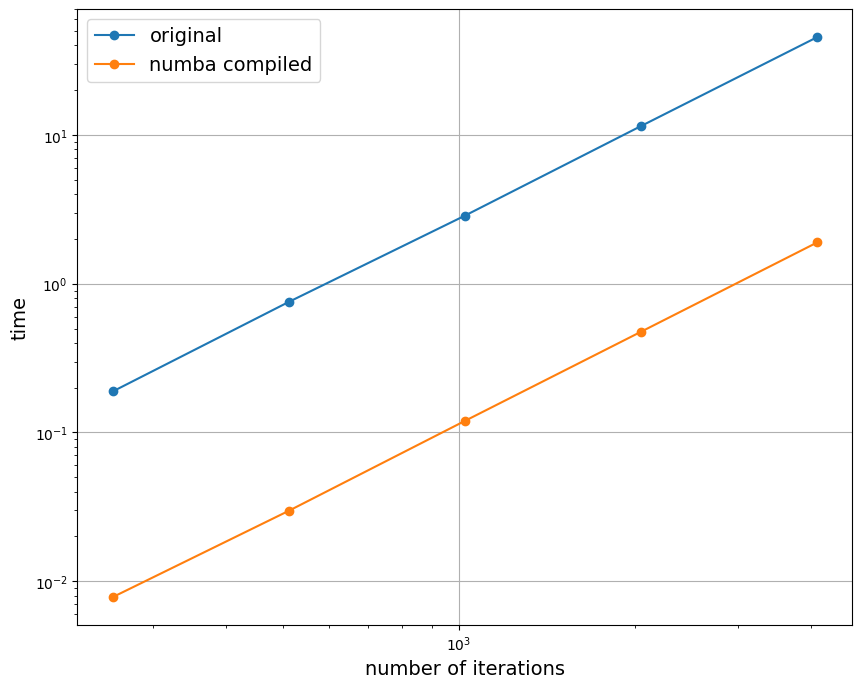

In [88]:
plt.figure(figsize=(10, 8))

plt.plot(nn, results_original_code, '-o', label='original')
plt.plot(nn, results_compiled_code, '-o', label='numba compiled')

plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('time', fontsize=14)

plt.yscale('log')
plt.xscale('log')

plt.legend(fontsize=14)
plt.grid()
plt.show()